In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 460kB 19.0MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 112kB 16.8MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=1be98163852c645108cbf6efe12998651e5fed15d0b27354383d79a532df2e8a
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=7f2d300d534e0dac629521eb72d2238b40257de303c61bda27eed2a422e0b6df
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=4e0b

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 24 11:09:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# config.data_dir =  './data/'

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar')

In [7]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import os
import sys
import time
from collections import OrderedDict
import random

import wandb



noise file noisy_label_kv50_sim.txt generated with noise: 0.5



In [0]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model


In [9]:
#This cell will not be necessary in the main, yet is required for this notebook

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
test_net = get_model()

if use_cuda:
    test_net.cuda()
    cudnn.benchmark = True

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()
consistent_criterion = torch.nn.KLDivLoss()



Model setup
| Building network: resnet34


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/models/resnet.py:122: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/models/resnet.py:124: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/models/resnet.py:125: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [10]:
print('\nLoading Checkpoint')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s_teacher_100.pth.tar' % config.id)

test_net.load_state_dict(checkpoint['state_dict'])


Loading Checkpoint


<All keys matched successfully>

In [0]:
# import noise_generator
# import random
# random.seed(30)
# import numpy
# numpy.random.seed(0)
# noise_generator.generate_noise(config.noise_rate,config.symmetric, config.data_dir, config.train_file_name, config.noise_validation, config.test_file_name)

In [0]:
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

In [0]:
def train_acc():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| train_loss: {:.3f}, train_acc: {:.3f}".format(
        loss.data.item(), test_acc)

    print(test_results)

In [37]:
# print('\nTesting model')
# checkpoint = config.drive_dir + '/checkpoint/%s_teacher_100.pth.tar' % config.id
# test_net.load_state_dict(checkpoint['state_dict'])
# test()


print('Train acc model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.checkpoint)
test_net.load_state_dict(checkpoint['state_dict'])
train_acc()

Train acc model
| train_loss: 2.042, train_acc: 41.218


In [38]:
# print('\nTesting model')
# checkpoint = config.drive_dir + '/checkpoint/%s_teacher_100.pth.tar' % config.id
# test_net.load_state_dict(checkpoint['state_dict'])
# test()


print('Train acc model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.checkpoint)
test_net.load_state_dict(checkpoint['state_dict'])
train_acc()

Train acc model
| train_loss: 1.968, train_acc: 41.293


In [0]:

# print('Train acc model')
# checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
# test_net.load_state_dict(checkpoint['state_dict'])
# train_acc()

In [0]:
import pandas

#Those parameters are key for discarding
config.batch_size = 1
config.shuffle = False

# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_noshuffle_loader, _, _ = loader.run()

In [0]:
import pandas
def get_confidence_training(dataloader):
  correct = 0
  total = 0

  target_list = []
  pred        = []
  confidence  = []

  # i = 0
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      # i += 1
      # if i>20:
      #   break
      if use_cuda:
          inputs, targets = inputs.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = test_net(inputs)
          loss = criterion(outputs, targets)  
          _, predicted = torch.max(outputs.data, 1)
          total += targets.size(0)
          correct += predicted.eq(targets.data).cpu().sum()
          
          conf = float(torch.max(outputs.softmax(dim = 1)))
          targ = int(targets.data)
          pd = int(predicted)
          # print(predicted)
          # print(conf,targ,pd)
          print(round(float(100.*correct/total),2))

          confidence.append(conf)
          target_list.append(targ)
          pred.append(pd)

  # Grab dataframe
  df = pandas.DataFrame()
  df["target_list"] = target_list
  df["pred"] = pred
  df["confidence"] = confidence

  return(df,correct,total)

In [41]:
df ,correct,total = get_confidence_training(train_noshuffle_loader)

Streaming output truncated to the last 5000 lines.
41.05
41.05
41.05
41.05
41.05
41.05
41.04
41.05
41.04
41.05
41.05
41.04
41.05
41.05
41.05
41.05
41.04
41.04
41.04
41.05
41.04
41.04
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.04
41.05
41.05
41.04
41.04
41.04
41.04
41.05
41.04
41.04
41.04
41.04
41.04
41.05
41.05
41.04
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.05
41.06
41.05
41.05
41.06
41.05
41.05
41.05
41.05
41.06
41.05
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.06
41.07
41.07
41.07
41.06
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.06
41.06
41.07
41.06
41.07
41.06
41.06
41.07
41.06
41.06
41.06
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
41.07
4

In [0]:
df.to_csv(config.data_dir + "confidences.csv")

In [43]:
df

,target_list,pred,confidence
0,6,8,0.221819
1,0,0,0.663569
2,0,0,0.262161
3,4,0,0.346407
4,8,0,0.338022
...,...,...,...
44995,7,9,0.352247
44996,4,9,0.388162
44997,0,1,0.284356
44998,9,9,0.415637


In [44]:
df.sort_values(by = ['confidence']).head(20)

,target_list,pred,confidence
13775,0,4,0.124748
13821,7,3,0.131118
7641,1,4,0.131148
40599,2,9,0.131217
24616,5,6,0.131400
12902,2,6,0.132439
10356,2,5,0.132953
3357,1,2,0.133038
7799,1,3,0.133385
44848,9,0,0.133439


In [45]:
df.sort_values(by = ['confidence']).tail(20)

,target_list,pred,confidence
14549,0,3,0.786606
13939,3,3,0.787421
19245,4,4,0.787704
19427,4,4,0.789045
14876,3,3,0.791638
18597,4,4,0.793672
4563,2,3,0.794180
15609,5,3,0.797161
20018,4,4,0.799285
19688,4,4,0.799382


In [46]:
df[df.target_list == df.pred].shape[0]/df.shape[0]

0.4121111111111111

In [0]:
config.train_dir = 'clean_train_key_list.txt'

In [0]:
#get list of directories
train_df = pandas.read_csv(config.data_dir+config.train_dir, header=None)
train_df.columns = ["dir"]
train_df

#Merge directories with confidence
DF = df.merge(train_df,how = 'left', left_index = True, right_index = True)

#
tau = 0.01
df_filtered = DF[DF.confidence > tau]
df_filtered

df_filtered["dir"].to_csv(config.data_dir +'clean_train_key_list_iter2' + config.id + '.txt', header = None, index=False)
config.train_dir = 'clean_train_key_list_iter2' + config.id + '.txt'

In [49]:
DF.sort_values(by = ['confidence']).tail(20)

,target_list,pred,confidence,dir
14549,0,3,0.786606,images/train/cat/1050.png
13939,3,3,0.787421,images/train/cat/0440.png
19245,4,4,0.787704,images/train/deer/1246.png
19427,4,4,0.789045,images/train/deer/1428.png
14876,3,3,0.791638,images/train/cat/1377.png
18597,4,4,0.793672,images/train/deer/0598.png
4563,2,3,0.794180,images/train/automobile/0064.png
15609,5,3,0.797161,images/train/cat/2110.png
20018,4,4,0.799285,images/train/deer/2019.png
19688,4,4,0.799382,images/train/deer/1689.png


In [50]:
DF.sort_values(by = ['confidence']).head(20)

,target_list,pred,confidence,dir
13775,0,4,0.124748,images/train/cat/0276.png
13821,7,3,0.131118,images/train/cat/0322.png
7641,1,4,0.131148,images/train/automobile/3142.png
40599,2,9,0.131217,images/train/truck/0100.png
24616,5,6,0.131400,images/train/dog/2117.png
12902,2,6,0.132439,images/train/bird/3903.png
10356,2,5,0.132953,images/train/bird/1357.png
3357,1,2,0.133038,images/train/airplane/3358.png
7799,1,3,0.133385,images/train/automobile/3300.png
44848,9,0,0.133439,images/train/truck/4349.png


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd5e5f9afd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


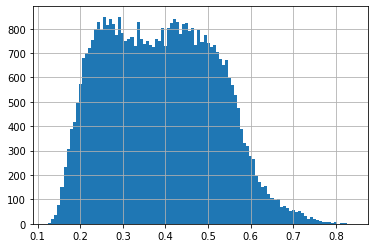

In [51]:
DF.confidence.hist(bins = 100)

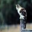

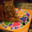

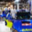

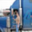

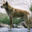

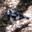

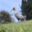

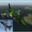

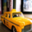

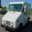

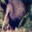

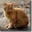

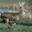

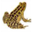

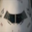

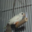

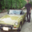

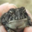

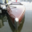

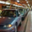

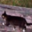

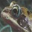

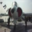

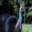

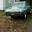

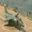

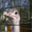

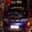

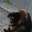

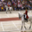

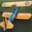

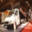

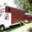

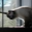

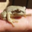

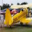

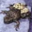

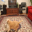

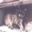

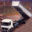

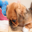

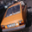

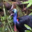

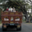

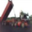

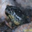

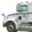

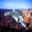

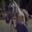

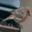

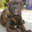

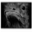

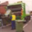

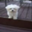

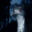

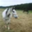

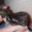

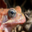

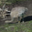

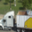

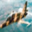

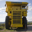

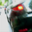

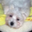

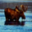

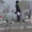

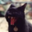

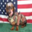

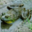

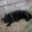

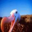

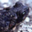

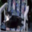

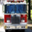

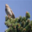

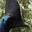

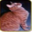

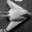

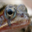

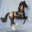

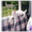

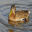

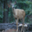

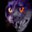

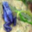

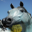

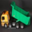

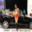

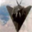

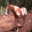

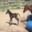

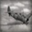

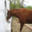

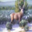

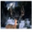

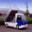

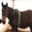

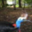

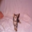

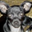

In [52]:
from IPython.display import Image

for img in DF.sort_values(by = ['confidence']).head(100).dir:
  x = Image(filename='/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:],width=100, height=100) 
  display(x)

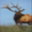

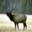

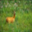

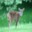

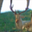

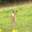

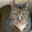

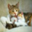

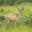

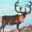

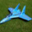

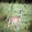

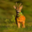

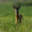

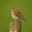

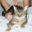

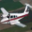

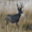

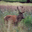

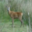

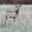

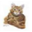

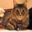

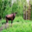

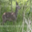

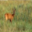

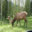

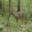

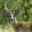

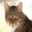

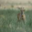

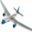

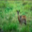

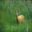

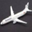

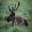

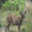

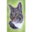

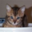

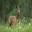

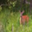

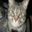

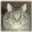

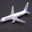

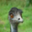

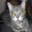

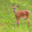

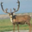

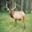

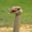

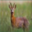

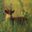

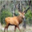

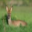

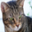

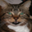

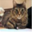

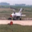

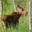

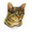

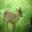

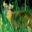

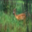

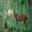

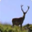

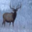

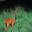

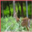

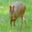

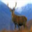

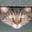

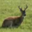

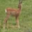

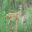

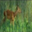

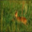

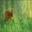

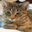

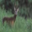

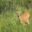

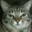

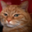

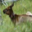

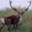

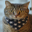

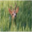

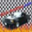

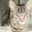

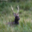

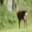

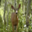

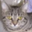

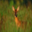

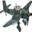

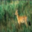

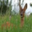

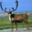

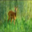

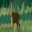

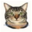

In [53]:
for img in DF.sort_values(by = ['confidence']).tail(100).dir:
  x = Image(filename='/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:],width=100, height=100) 
  display(x)

# Top Representants per classe

In [78]:
top_confidence = pandas.DataFrame()
for p in set(DF.pred):
  df_tmp = DF[DF.pred == p][["confidence", "dir","pred"]].sort_values(["confidence"], ascending = False).head(10).copy()
  top_confidence = pandas.concat([top_confidence, df_tmp.T], axis = 1)

top_confidence = top_confidence.T
top_confidence

,confidence,dir,pred
1673,0.807668,images/train/airplane/1674.png,0
1953,0.76751,images/train/airplane/1954.png,0
911,0.758251,images/train/airplane/0912.png,0
438,0.754737,images/train/airplane/0439.png,0
3053,0.753082,images/train/airplane/3054.png,0
...,...,...,...
43660,0.593847,images/train/truck/3161.png,9
41770,0.591365,images/train/truck/1271.png,9
41856,0.589555,images/train/truck/1357.png,9
43785,0.587235,images/train/truck/3286.png,9


In [79]:
for p in set(top_confidence.pred):
  # print(top_confidence[top_confidence.pred == p])
  df_class = top_confidence[top_confidence.pred == p]
  img_lst = []
  for img in df_class.dir:
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:], 'rb').read(),width=100, height=100))
  hbox = HBox(img_lst)
  display(hbox)


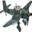

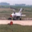

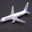

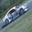

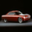

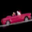

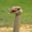

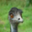

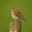

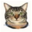

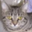

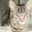

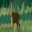

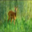

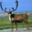

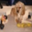

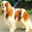

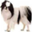

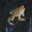

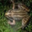

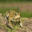

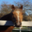

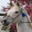

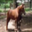

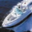

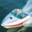

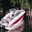

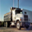

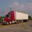

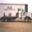

In [62]:
for img in top_confidence.dir:
  x = Image(filename='/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:],width=100, height=100) 
  display(x)

In [80]:
bottom_confidence = pandas.DataFrame()
for p in set(DF.pred):
  df_tmp = DF[DF.pred == p][["confidence", "dir","pred"]].sort_values(["confidence"], ascending = True).head(10).copy()
  bottom_confidence = pandas.concat([bottom_confidence, df_tmp.T], axis = 1)

bottom_confidence = bottom_confidence.T
bottom_confidence

,confidence,dir,pred
44848,0.133439,images/train/truck/4349.png,0
20156,0.135108,images/train/deer/2157.png,0
2317,0.135969,images/train/airplane/2318.png,0
1701,0.140521,images/train/airplane/1702.png,0
87,0.141621,images/train/airplane/0088.png,0
...,...,...,...
11937,0.145765,images/train/bird/2938.png,9
40973,0.146337,images/train/truck/0474.png,9
28038,0.14731,images/train/frog/1039.png,9
43398,0.147867,images/train/truck/2899.png,9


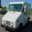

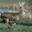

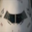

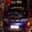

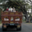

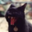

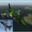

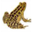

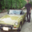

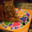

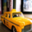

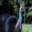

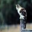

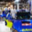

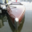

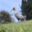

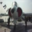

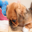

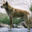

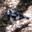

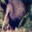

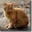

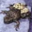

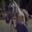

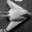

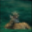

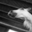

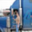

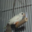

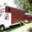

In [71]:
for img in bottom_confidence.dir:
  x = Image(filename='/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:],width=100, height=100) 
  display(x)

In [81]:
for p in set(bottom_confidence.pred):
  # print(top_confidence[top_confidence.pred == p])
  df_class = bottom_confidence[bottom_confidence.pred == p]
  img_lst = []
  for img in df_class.dir:
    img_lst.append(widgets.Image(value=open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_cifar/data/' + img[7:], 'rb').read(),width=100, height=100))
  hbox = HBox(img_lst)
  display(hbox)


In [77]:
bottom_confidence

,confidence,dir,pred
44848,0.133439,images/train/truck/4349.png,0
20156,0.135108,images/train/deer/2157.png,0
2317,0.135969,images/train/airplane/2318.png,0
5088,0.139916,images/train/automobile/0589.png,1
42621,0.143211,images/train/truck/2122.png,1
14823,0.146657,images/train/cat/1324.png,1
3357,0.133038,images/train/airplane/3358.png,2
28441,0.135122,images/train/frog/1442.png,2
6005,0.136898,images/train/automobile/1506.png,2
13821,0.131118,images/train/cat/0322.png,3
